# Visualizing Maximum Activation Images
### from keras blog (https://blog.keras.io/category/demo.html)

define VGG16 model 

In [1]:
from keras import applications

model = applications.VGG16(include_top=False,
                           weights='imagenet')

Using TensorFlow backend.


Note that we only go up to the last convolutional layer --we don't include fully-connected layers. The reason is that adding the fully connected layers forces you to use a fixed input size for the model (224x224, the original ImageNet format). By only keeping the convolutional modules, our model can be adapted to arbitrary input sizes.

In [26]:
img_width = 128
img_height = 128

input_img = model.input

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers])

for key, val in layer_dict.items():
    print(key + ": " + str(val))

block2_conv2: <keras.layers.convolutional.Conv2D object at 0x10e66ccc0>
block1_pool: <keras.layers.pooling.MaxPooling2D object at 0x10e638978>
block4_pool: <keras.layers.pooling.MaxPooling2D object at 0x10e8a6780>
block5_conv3: <keras.layers.convolutional.Conv2D object at 0x10e8e6da0>
block2_pool: <keras.layers.pooling.MaxPooling2D object at 0x10e69ad68>
block3_conv1: <keras.layers.convolutional.Conv2D object at 0x10e6ca978>
block4_conv1: <keras.layers.convolutional.Conv2D object at 0x10e83d4a8>
block3_pool: <keras.layers.pooling.MaxPooling2D object at 0x10e81ec50>
block4_conv3: <keras.layers.convolutional.Conv2D object at 0x10e865780>
block5_conv1: <keras.layers.convolutional.Conv2D object at 0x10e8b7b38>
block2_conv1: <keras.layers.convolutional.Conv2D object at 0x10e690b70>
block1_conv1: <keras.layers.convolutional.Conv2D object at 0x1034c3f28>
block5_conv2: <keras.layers.convolutional.Conv2D object at 0x10e8b0860>
input_1: <keras.engine.topology.InputLayer object at 0x1047a77f0>
bl

Now let's define a loss function that will seek to maximize the activation of a specific filter (filter_index) in a specific layer (layer_name).   
We do this via a Keras backend function, which allows our code to run both on top of TensorFlow and Theano.

In [19]:
from keras import backend as K

layer_name = 'block5_conv3'
filter_index = 0  # can be any integer from 0 to 511, as there are 512 filters in that layer

## TODO: investigate keras layers  

In [32]:
# build a loss function that maximizes the activation of the nth filter of the layer considered
layer_output = layer_dict[layer_name].output
if K.image_data_format() == 'channels_first':
    loss = K.mean(layer_output[:, filter_index, :, :])
else:
    loss = K.mean(layer_output[:, :, :, filter_index])

(4) Visualize image responsible for a node activation (by doing gradient descent to maximize that node)

to do this, specify a particular node/neuron in the filter as the new loss function 

## TODO: investigate keras.backend gradient mechanism 

In [33]:
# compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, input_img)[0]

# normalization trick: we normalize the gradient
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

All very simple. The only trick here is to normalize the gradient of the pixels of the input image, which avoids very small and very large gradients and ensures a smooth gradient ascent process.

## TODO: investigate keras.backend funtion mechanism 

In [34]:
# this function returns the loss and grads given the input picture
iterate = K.function([input_img], [loss, grads])

Now we can use the Keras function we defined to do gradient ascent in the input space, with regard to our filter activation loss:

In [38]:
import numpy as np

# we start from a gray image with some noise
# we start from a gray image with some random noise
if K.image_data_format() == 'channels_first':
    input_img_data = np.random.random((1, 3, img_width, img_height))
else:
    input_img_data = np.random.random((1, img_width, img_height, 3))
input_img_data = (input_img_data - 0.5) * 20 + 128

In [46]:
# run gradient ascent for 20 steps
step = 1

for i in range(50):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

display generated images 

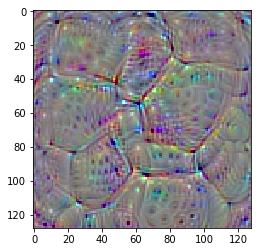

In [47]:
from scipy.misc import imsave
from matplotlib import pyplot as plt
%matplotlib inline 

# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5    # center to 0.5 for the [0, 1] interval
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

img = input_img_data[0]
img = deprocess_image(img)
imsave('%s_filter_%d.png' % (layer_name, filter_index), img)
plt.imshow(img)